In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
import graphviz

In [2]:
# Loads the data into a dataframe
df = pd.read_csv('./data/Jan_2019_ontime.csv')
df.shape

(583985, 22)

In [3]:
# Drops column with no data and reduces the data to just a small sample for establishing a baseline
df = df.sample(frac=0.05)
df = df.drop('Unnamed: 21', axis=1)
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
330295,18,5,WN,19393,WN,N7711N,1060,14908,1490803,SNA,...,1288903,LAS,703.0,0.0,0700-0759,817.0,0.0,0.0,0.0,226.0
378158,21,1,UA,19977,UA,N834UA,238,11278,1127805,DCA,...,1393007,ORD,1742.0,0.0,1700-1759,1916.0,0.0,0.0,0.0,612.0
195556,11,5,OO,20304,OO,N713SK,3268,11298,1129806,DFW,...,1244807,JAN,1614.0,1.0,1400-1459,1728.0,1.0,0.0,0.0,408.0
45506,3,4,OO,20304,OO,N173SY,3479,14057,1405702,PDX,...,1071302,BOI,2147.0,0.0,2100-2159,2353.0,0.0,0.0,0.0,344.0
440632,24,4,9E,20363,9E,N819AY,5242,13930,1393007,ORD,...,1119302,CVG,1554.0,1.0,1500-1559,1831.0,1.0,0.0,0.0,264.0


In [4]:
# Since OP_CARRIER and OP_UNIQUE_CARRIER columns are identical, we can remove one of them
df = df.drop('OP_UNIQUE_CARRIER', axis=1)
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
330295,18,5,19393,WN,N7711N,1060,14908,1490803,SNA,12889,1288903,LAS,703.0,0.0,0700-0759,817.0,0.0,0.0,0.0,226.0
378158,21,1,19977,UA,N834UA,238,11278,1127805,DCA,13930,1393007,ORD,1742.0,0.0,1700-1759,1916.0,0.0,0.0,0.0,612.0
195556,11,5,20304,OO,N713SK,3268,11298,1129806,DFW,12448,1244807,JAN,1614.0,1.0,1400-1459,1728.0,1.0,0.0,0.0,408.0
45506,3,4,20304,OO,N173SY,3479,14057,1405702,PDX,10713,1071302,BOI,2147.0,0.0,2100-2159,2353.0,0.0,0.0,0.0,344.0
440632,24,4,20363,9E,N819AY,5242,13930,1393007,ORD,11193,1119302,CVG,1554.0,1.0,1500-1559,1831.0,1.0,0.0,0.0,264.0


In [5]:
df = df.dropna()

In [6]:
# Calculates a baseline error for predicting whether a flight's arrival is delayed for more than 15 minutes
df.ARR_DEL15.value_counts()

0.0    23093
1.0     5217
Name: ARR_DEL15, dtype: int64

In [7]:
# Our baseline accuracy is ~0.816 and baseline error is ~0.184
baseline_accuracy = 23068 / (23068 + 5203)
baseline_accuracy

0.8159598174808107

In [8]:
baseline_error = 1 - baseline_accuracy
baseline_error

0.1840401825191893

In [9]:
# Removes some unnessecary features for creating a simple classifier
X = df.drop(['ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'OP_CARRIER_AIRLINE_ID',
             'DEP_TIME_BLK', 'DEP_DEL15', 'ARR_DEL15', 'ARR_TIME', 'CANCELLED', 'DIVERTED'], axis=1)
y = df.ARR_DEL15
X.DAY_OF_MONTH = X.DAY_OF_MONTH.astype('category')
X.DAY_OF_WEEK = X.DAY_OF_WEEK.astype('category')
X.OP_CARRIER_FL_NUM = X.OP_CARRIER_FL_NUM.astype('category')
X.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,DEP_TIME,DISTANCE
330295,18,5,WN,N7711N,1060,SNA,LAS,703.0,226.0
378158,21,1,UA,N834UA,238,DCA,ORD,1742.0,612.0
195556,11,5,OO,N713SK,3268,DFW,JAN,1614.0,408.0
45506,3,4,OO,N173SY,3479,PDX,BOI,2147.0,344.0
440632,24,4,9E,N819AY,5242,ORD,CVG,1554.0,264.0


In [10]:
# One-hot-encodes categorical features
X = pd.get_dummies(X)
X.head()

,DEP_TIME,DISTANCE,DAY_OF_MONTH_1,DAY_OF_MONTH_2,DAY_OF_MONTH_3,DAY_OF_MONTH_4,DAY_OF_MONTH_5,DAY_OF_MONTH_6,DAY_OF_MONTH_7,DAY_OF_MONTH_8,...,DEST_TYS,DEST_UIN,DEST_USA,DEST_VEL,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YUM
330295,703.0,226.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
378158,1742.0,612.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
195556,1614.0,408.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
45506,2147.0,344.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
440632,1554.0,264.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Decision Tree
tree = DecisionTreeClassifier(max_depth = 2)
tree.fit(X,y)

DecisionTreeClassifier(max_depth=2)

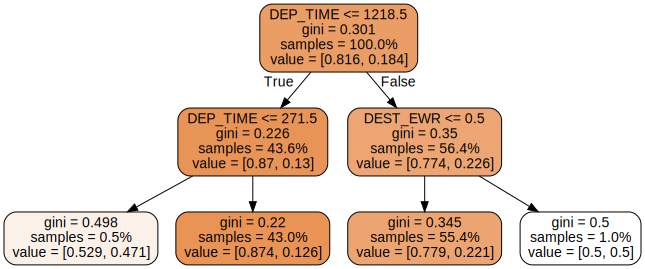

In [15]:
dot_data = export_graphviz(tree,
                           out_file=None,
                           feature_names=X.columns,
                           proportion=True,
                           impurity=True,
                           filled=True,
                           rounded=True)
graph = graphviz.Source(dot_data)
graph

In [16]:
# Validation
grid = {'max_depth': np.arange(1, 10)}
tree = DecisionTreeClassifier()
treeCV = GridSearchCV(tree, param_grid=grid, return_train_score=True)

treeCV.fit(X, y)

print('best tree depth', treeCV.best_params_)

print('valid error rate', (1 - treeCV.best_score_).round(3))

best tree depth {'max_depth': 9}
valid error rate 0.177


In [17]:
val_accuracy = treeCV.best_score_
print('valid acc', val_accuracy.round(3))

valid acc 0.823


<AxesSubplot:xlabel='depth'>

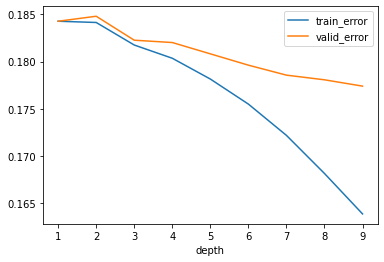

In [18]:
results = pd.DataFrame()
results['depth'] = grid['max_depth']
results['train_error'] = 1 - treeCV.cv_results_['mean_train_score']
results['valid_error'] = 1 - treeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x = 'depth', y = 'train_error')
results.plot.line(x = 'depth', y = 'valid_error', ax = ax1)